# Import basic libraries needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import the data

In [2]:
start_date = '2000-01-01'
end_date = '2018-01-01'

In [3]:
'''
import pandas_datareader as pdr

df_to_save = pdr.DataReader(name='AAPL', data_source='yahoo', start=start_date, end=end_date)
df_to_save.head(5)

df_to_save.to_csv('AAPL_YAHOO.csv')

'''

df = pd.read_csv('AAPL_YAHOO6.csv', index_col='Date', parse_dates=True)

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,2.655498
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,2.431611
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,2.467196
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.253689
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,2.360442


In [5]:
df_close = df[['Close']].copy()
#df_close['Index'] = np.arange(len(df_close))
df_close.head()

,Close
Date,
2000-01-03,3.997768
2000-01-04,3.660714
2000-01-05,3.714286
2000-01-06,3.392857
2000-01-07,3.553571


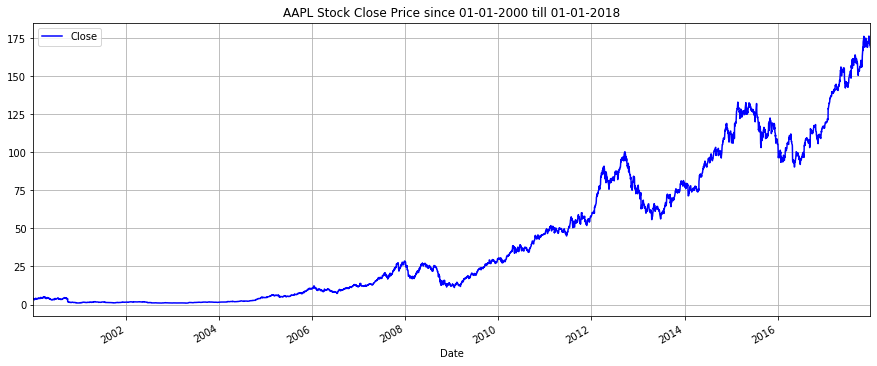

In [6]:
df_close.plot(figsize=(15, 6), 
                         color='blue', 
                         grid=True, 
                         title='AAPL Stock Close Price since 01-01-2000 till 01-01-2018')

# Train / Test split

In [7]:
len(df_close)

4528

In [8]:
# Train
train = df_close.iloc[:4400] # pandas.core.series.Series (4500,) **
train_index = train.index # pandas.core.indexes.datetimes.DatetimeIndex

# Test # 28 sessions
test = df_close.iloc[4400:] # pandas.core.series.Series (28,) **
test_index = test.index # pandas.core.indexes.datetimes.DatetimeIndex

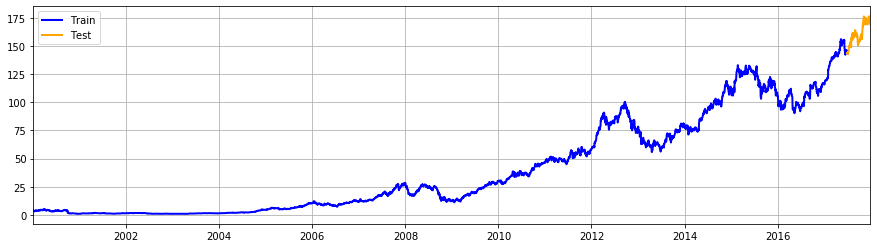

In [9]:
plt.figure(figsize=(15, 4))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train, lw=2, color='blue')
plt.plot(test, lw=2, color='orange')
plt.legend(['Train', 'Test'])

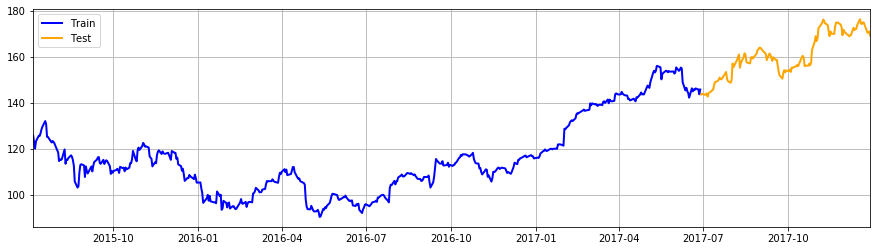

In [10]:
plt.figure(figsize=(15, 4))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train[-500:], lw=2, color='blue')
plt.plot(test, lw=2, color='orange')
plt.legend(['Train', 'Test'])

# Data preprocessing

### 1)  ```sklearn.preprocessing.MinMaxScaler()``` - data range made between 0 and 1

In [11]:
from sklearn.preprocessing import MinMaxScaler 

In [12]:
# From Pandas TimeSeries into NumPy array
# Train
train = train.values # numpy.ndarray (4400,)
train = train.reshape((len(train), 1)) # numpy.ndarray (4400, 1)

# Test
test = test.values # numpy.ndarray (128,)
test = test.reshape((len(test), 1)) # numpy.ndarray (128, 1)

In [13]:
# Fit the train data only sicne we don't want to give any additional info about values that model will predict
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
# Transform the data then export to Pandas TimeSeries as began
# Train
train_norm = scaler.transform(train) # numpy.ndarray (4400, 1)
train_norm = train_norm.tolist() # list of single value lists [[x], [y], [z]]
train_norm = np.squeeze(train_norm) # numpy.ndarray array([x, y, z])
train_norm = pd.Series(train_norm, train_index) # pandas.core.series.Series (4500,) **

# Test
test_norm = scaler.transform(test) # numpy.ndarray (128, 1)
test_norm = test_norm.tolist() # list of single value lists [[x], [y], [z]]
test_norm = np.squeeze(test_norm) # numpy.ndarray array([x, y, z])
test_norm = pd.Series(test_norm, test_index) # pandas.core.series.Series (28,) **

In [15]:
train_norm.head()

Date
2000-01-03    0.019725
2000-01-04    0.017553
2000-01-05    0.017898
2000-01-06    0.015827
2000-01-07    0.016862
dtype: float64

### 2) ```TimeseriesGenerator()``` - prepare train chunks for feeding model purposes.

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [17]:
n_input = 20

# All data and every single target are placed in the same set: train_norm
generator = TimeseriesGenerator(data=train_norm,
                                targets=train_norm,
                                length=n_input,
                                batch_size=1)

# SECOND

In [18]:
n_input2 = 40

# All data and every single target are placed in the same set: train_norm
generator2 = TimeseriesGenerator(data=train_norm,
                                targets=train_norm,
                                length=n_input2,
                                batch_size=1)

# Model building

## Model with generator 1
```n_input = 20```

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

# Model fit

In [20]:
import time

## Model fit with generator

In [21]:
elapsed_all = []
for i in range(3):
    model = Sequential()

    # n_input = 20
    model.add(Dense(20, activation='sigmoid', input_dim=n_input))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='sgd', loss='mse')

    
    
    start = time.time()

    model.fit_generator(generator=generator, 
                        epochs=500,
                        verbose=2)
                        #, steps_per_epoch=1) # by default when not specified = len(generator)
    end = time.time()
    elapsed = end - start
    elapsed_all.append(elapsed/60)
    
    # Model save
    model.save("my_MODEL1-sigmoid-sigmoid-linear-sgd_gen" + str(i) + ".h5")
    
    # Loss hist save
    pd.DataFrame(np.array(model.history.history['loss'])).to_csv("my_MODEL1-sigmoid-sigmoid-linear-sgd_gen_LOSS" + str(i) + ".csv")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 11s - loss: 0.0211
Epoch 2/500
 - 8s - loss: 6.2300e-04
Epoch 3/500
 - 8s - loss: 5.7873e-04
Epoch 4/500
 - 8s - loss: 5.4729e-04
Epoch 5/500
 - 8s - loss: 5.1813e-04
Epoch 6/500
 - 9s - loss: 4.9765e-04
Epoch 7/500
 - 9s - loss: 4.7629e-04
Epoch 8/500
 - 7s - loss: 4.5760e-04
Epoch 9/500
 - 7s - loss: 4.4223e-04
Epoch 10/500
 - 8s - loss: 4.2742e-04
Epoch 11/500
 - 8s - loss: 4.1585e-04
Epoch 12/500
 - 8s - loss: 4.0051e-04
Epoch 13/500
 - 9s - loss: 3.8743e-04
Epoch 14/500
 - 9s - loss: 3.7894e-04
Epoch 15/500
 - 8s - loss: 3.7317e-04
Epoch 16/500
 - 8s - loss: 3.6025e-04
Epoch 17/500
 - 8s - loss: 3.5188e-04
Epoch 18/500
 - 8s - loss: 3.4298e-04
Epoch 19/500
 - 8s - loss: 3.3708e-04
Epoch 20/500
 - 7s - loss: 3.3159e-04
Epoch 21/500
 - 7s - loss: 3.2644e-04
Epoch 22/500
 - 7s - loss: 3.1853e-04
Epoch 23/500
 - 7s - loss: 3.1474e-04
Epoch 24/500
 - 7s

Epoch 198/500
 - 7s - loss: 9.9893e-05
Epoch 199/500
 - 7s - loss: 1.0075e-04
Epoch 200/500
 - 7s - loss: 1.0096e-04
Epoch 201/500
 - 7s - loss: 1.0082e-04
Epoch 202/500
 - 7s - loss: 9.9162e-05
Epoch 203/500
 - 7s - loss: 1.0007e-04
Epoch 204/500
 - 7s - loss: 9.9277e-05
Epoch 205/500
 - 7s - loss: 9.8262e-05
Epoch 206/500
 - 7s - loss: 9.8946e-05
Epoch 207/500
 - 7s - loss: 9.8925e-05
Epoch 208/500
 - 7s - loss: 9.9004e-05
Epoch 209/500
 - 7s - loss: 9.7736e-05
Epoch 210/500
 - 7s - loss: 9.7670e-05
Epoch 211/500
 - 7s - loss: 9.8231e-05
Epoch 212/500
 - 7s - loss: 9.7412e-05
Epoch 213/500
 - 7s - loss: 9.6828e-05
Epoch 214/500
 - 7s - loss: 9.6788e-05
Epoch 215/500
 - 7s - loss: 9.6228e-05
Epoch 216/500
 - 7s - loss: 9.6697e-05
Epoch 217/500
 - 7s - loss: 9.6448e-05
Epoch 218/500
 - 7s - loss: 9.7184e-05
Epoch 219/500
 - 7s - loss: 9.5364e-05
Epoch 220/500
 - 7s - loss: 9.6005e-05
Epoch 221/500
 - 7s - loss: 9.5581e-05
Epoch 222/500
 - 7s - loss: 9.5513e-05
Epoch 223/500
 - 7s - los

 - 7s - loss: 7.0967e-05
Epoch 409/500
 - 7s - loss: 7.0737e-05
Epoch 410/500
 - 7s - loss: 7.0189e-05
Epoch 411/500
 - 7s - loss: 6.9988e-05
Epoch 412/500
 - 7s - loss: 7.0262e-05
Epoch 413/500
 - 7s - loss: 7.0073e-05
Epoch 414/500
 - 7s - loss: 6.9784e-05
Epoch 415/500
 - 7s - loss: 7.0309e-05
Epoch 416/500
 - 7s - loss: 6.9674e-05
Epoch 417/500
 - 7s - loss: 6.9917e-05
Epoch 418/500
 - 7s - loss: 7.0197e-05
Epoch 419/500
 - 7s - loss: 7.0144e-05
Epoch 420/500
 - 7s - loss: 6.9649e-05
Epoch 421/500
 - 7s - loss: 6.9124e-05
Epoch 422/500
 - 7s - loss: 6.9227e-05
Epoch 423/500
 - 7s - loss: 6.9405e-05
Epoch 424/500
 - 7s - loss: 6.8551e-05
Epoch 425/500
 - 7s - loss: 6.9140e-05
Epoch 426/500
 - 7s - loss: 6.9334e-05
Epoch 427/500
 - 7s - loss: 6.9525e-05
Epoch 428/500
 - 7s - loss: 6.9362e-05
Epoch 429/500
 - 7s - loss: 6.9307e-05
Epoch 430/500
 - 7s - loss: 6.9188e-05
Epoch 431/500
 - 7s - loss: 6.8996e-05
Epoch 432/500
 - 7s - loss: 6.8528e-05
Epoch 433/500
 - 7s - loss: 6.8835e-05


 - 7s - loss: 1.0613e-04
Epoch 122/500
 - 7s - loss: 1.0576e-04
Epoch 123/500
 - 7s - loss: 1.0508e-04
Epoch 124/500
 - 7s - loss: 1.0381e-04
Epoch 125/500
 - 7s - loss: 1.0394e-04
Epoch 126/500
 - 7s - loss: 1.0228e-04
Epoch 127/500
 - 7s - loss: 1.0253e-04
Epoch 128/500
 - 7s - loss: 1.0156e-04
Epoch 129/500
 - 7s - loss: 1.0249e-04
Epoch 130/500
 - 7s - loss: 1.0168e-04
Epoch 131/500
 - 7s - loss: 1.0111e-04
Epoch 132/500
 - 7s - loss: 1.0032e-04
Epoch 133/500
 - 7s - loss: 1.0107e-04
Epoch 134/500
 - 7s - loss: 1.0011e-04
Epoch 135/500
 - 7s - loss: 9.9017e-05
Epoch 136/500
 - 7s - loss: 9.8556e-05
Epoch 137/500
 - 7s - loss: 9.8627e-05
Epoch 138/500
 - 7s - loss: 9.7638e-05
Epoch 139/500
 - 7s - loss: 9.7296e-05
Epoch 140/500
 - 7s - loss: 9.7824e-05
Epoch 141/500
 - 7s - loss: 9.7160e-05
Epoch 142/500
 - 7s - loss: 9.6048e-05
Epoch 143/500
 - 7s - loss: 9.7005e-05
Epoch 144/500
 - 7s - loss: 9.5537e-05
Epoch 145/500
 - 7s - loss: 9.6237e-05
Epoch 146/500
 - 7s - loss: 9.4568e-05


Epoch 332/500
 - 7s - loss: 6.6308e-05
Epoch 333/500
 - 7s - loss: 6.5892e-05
Epoch 334/500
 - 7s - loss: 6.5884e-05
Epoch 335/500
 - 7s - loss: 6.5704e-05
Epoch 336/500
 - 7s - loss: 6.4844e-05
Epoch 337/500
 - 7s - loss: 6.5867e-05
Epoch 338/500
 - 7s - loss: 6.5320e-05
Epoch 339/500
 - 7s - loss: 6.5262e-05
Epoch 340/500
 - 7s - loss: 6.5160e-05
Epoch 341/500
 - 7s - loss: 6.4930e-05
Epoch 342/500
 - 7s - loss: 6.4750e-05
Epoch 343/500
 - 7s - loss: 6.5410e-05
Epoch 344/500
 - 7s - loss: 6.3975e-05
Epoch 345/500
 - 7s - loss: 6.4679e-05
Epoch 346/500
 - 7s - loss: 6.5006e-05
Epoch 347/500
 - 7s - loss: 6.4411e-05
Epoch 348/500
 - 7s - loss: 6.4964e-05
Epoch 349/500
 - 7s - loss: 6.4548e-05
Epoch 350/500
 - 7s - loss: 6.4463e-05
Epoch 351/500
 - 7s - loss: 6.4417e-05
Epoch 352/500
 - 7s - loss: 6.4797e-05
Epoch 353/500
 - 7s - loss: 6.3941e-05
Epoch 354/500
 - 7s - loss: 6.3847e-05
Epoch 355/500
 - 7s - loss: 6.3463e-05
Epoch 356/500
 - 7s - loss: 6.3781e-05
Epoch 357/500
 - 7s - los

Epoch 44/500
 - 7s - loss: 2.5115e-04
Epoch 45/500
 - 7s - loss: 2.4915e-04
Epoch 46/500
 - 7s - loss: 2.4601e-04
Epoch 47/500
 - 7s - loss: 2.4373e-04
Epoch 48/500
 - 7s - loss: 2.3878e-04
Epoch 49/500
 - 7s - loss: 2.3603e-04
Epoch 50/500
 - 7s - loss: 2.3457e-04
Epoch 51/500
 - 7s - loss: 2.3216e-04
Epoch 52/500
 - 7s - loss: 2.2763e-04
Epoch 53/500
 - 7s - loss: 2.2531e-04
Epoch 54/500
 - 7s - loss: 2.2191e-04
Epoch 55/500
 - 7s - loss: 2.1920e-04
Epoch 56/500
 - 7s - loss: 2.1579e-04
Epoch 57/500
 - 7s - loss: 2.1576e-04
Epoch 58/500
 - 7s - loss: 2.1289e-04
Epoch 59/500
 - 7s - loss: 2.0906e-04
Epoch 60/500
 - 7s - loss: 2.0921e-04
Epoch 61/500
 - 7s - loss: 2.0551e-04
Epoch 62/500
 - 7s - loss: 2.0228e-04
Epoch 63/500
 - 7s - loss: 2.0090e-04
Epoch 64/500
 - 7s - loss: 1.9756e-04
Epoch 65/500
 - 7s - loss: 1.9608e-04
Epoch 66/500
 - 7s - loss: 1.9256e-04
Epoch 67/500
 - 7s - loss: 1.9355e-04
Epoch 68/500
 - 7s - loss: 1.9014e-04
Epoch 69/500
 - 7s - loss: 1.8893e-04
Epoch 70/500

Epoch 256/500
 - 7s - loss: 8.1758e-05
Epoch 257/500
 - 7s - loss: 8.0943e-05
Epoch 258/500
 - 7s - loss: 8.0958e-05
Epoch 259/500
 - 7s - loss: 8.1040e-05
Epoch 260/500
 - 7s - loss: 8.1210e-05
Epoch 261/500
 - 7s - loss: 8.0048e-05
Epoch 262/500
 - 7s - loss: 8.0598e-05
Epoch 263/500
 - 7s - loss: 7.9580e-05
Epoch 264/500
 - 7s - loss: 8.0320e-05
Epoch 265/500
 - 7s - loss: 7.9908e-05
Epoch 266/500
 - 7s - loss: 7.9792e-05
Epoch 267/500
 - 7s - loss: 8.0130e-05
Epoch 268/500
 - 7s - loss: 7.9894e-05
Epoch 269/500
 - 7s - loss: 7.9446e-05
Epoch 270/500
 - 7s - loss: 7.9974e-05
Epoch 271/500
 - 7s - loss: 7.9995e-05
Epoch 272/500
 - 7s - loss: 7.8510e-05
Epoch 273/500
 - 7s - loss: 7.9027e-05
Epoch 274/500
 - 7s - loss: 7.8740e-05
Epoch 275/500
 - 7s - loss: 7.8662e-05
Epoch 276/500
 - 7s - loss: 7.8625e-05
Epoch 277/500
 - 7s - loss: 7.8546e-05
Epoch 278/500
 - 7s - loss: 7.8619e-05
Epoch 279/500
 - 7s - loss: 7.8390e-05
Epoch 280/500
 - 7s - loss: 7.8515e-05
Epoch 281/500
 - 7s - los

 - 7s - loss: 6.3576e-05
Epoch 467/500
 - 7s - loss: 6.3967e-05
Epoch 468/500
 - 7s - loss: 6.3486e-05
Epoch 469/500
 - 7s - loss: 6.3767e-05
Epoch 470/500
 - 7s - loss: 6.4554e-05
Epoch 471/500
 - 7s - loss: 6.4170e-05
Epoch 472/500
 - 7s - loss: 6.4166e-05
Epoch 473/500
 - 7s - loss: 6.4708e-05
Epoch 474/500
 - 7s - loss: 6.3641e-05
Epoch 475/500
 - 7s - loss: 6.3929e-05
Epoch 476/500
 - 7s - loss: 6.2857e-05
Epoch 477/500
 - 7s - loss: 6.3847e-05
Epoch 478/500
 - 7s - loss: 6.3772e-05
Epoch 479/500
 - 7s - loss: 6.3376e-05
Epoch 480/500
 - 7s - loss: 6.3888e-05
Epoch 481/500
 - 7s - loss: 6.3347e-05
Epoch 482/500
 - 7s - loss: 6.3442e-05
Epoch 483/500
 - 7s - loss: 6.3916e-05
Epoch 484/500
 - 7s - loss: 6.3415e-05
Epoch 485/500
 - 7s - loss: 6.3535e-05
Epoch 486/500
 - 7s - loss: 6.3488e-05
Epoch 487/500
 - 7s - loss: 6.3185e-05
Epoch 488/500
 - 7s - loss: 6.3444e-05
Epoch 489/500
 - 7s - loss: 6.3678e-05
Epoch 490/500
 - 7s - loss: 6.3216e-05
Epoch 491/500
 - 7s - loss: 6.2854e-05


In [33]:
elapsed_all
# [60.184498862425485, 60.41519705454508, 60.79986066420873]

[60.184498862425485, 60.41519705454508, 60.79986066420873]

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________


## Model fit with generator2 (2)

In [30]:
elapsed3_all = []
for i in range(3):
    model3 = Sequential()

    # n_input = 20
    model3.add(Dense(40, activation='sigmoid', input_dim=n_input2))
    model3.add(Dense(40, activation='sigmoid'))
    model3.add(Dense(1, activation='linear'))

    model3.compile(optimizer='sgd', loss='mse')

    
    
    start3 = time.time()

    model3.fit_generator(generator=generator2, 
                        epochs=500,
                        verbose=2)
                        #, steps_per_epoch=1) # by default when not specified = len(generator)
    end3 = time.time()
    elapsed3 = end3 - start3
    elapsed3_all.append(elapsed3/60)
    
    # Model save
    model3.save("my_MODEL1-sigmoid-sigmoid-linear-sgd_gen2_2" + str(i) + ".h5")
    
    # Loss hist save
    pd.DataFrame(np.array(model3.history.history['loss'])).to_csv("my_MODEL1-sigmoid-sigmoid-linear-sgd_gen2_2_LOSS" + str(i) + ".csv")

Epoch 1/500
 - 4s - loss: 0.0099
Epoch 2/500
 - 5s - loss: 9.9880e-04
Epoch 3/500
 - 7s - loss: 9.1483e-04
Epoch 4/500
 - 6s - loss: 8.4911e-04
Epoch 5/500
 - 6s - loss: 7.9143e-04
Epoch 6/500
 - 6s - loss: 7.4565e-04
Epoch 7/500
 - 7s - loss: 7.0848e-04
Epoch 8/500
 - 6s - loss: 6.7196e-04
Epoch 9/500
 - 6s - loss: 6.4100e-04
Epoch 10/500
 - 6s - loss: 6.1103e-04
Epoch 11/500
 - 6s - loss: 5.8371e-04
Epoch 12/500
 - 6s - loss: 5.6455e-04
Epoch 13/500
 - 6s - loss: 5.4254e-04
Epoch 14/500
 - 7s - loss: 5.2389e-04
Epoch 15/500
 - 6s - loss: 5.0217e-04
Epoch 16/500
 - 6s - loss: 4.7501e-04
Epoch 17/500
 - 6s - loss: 4.6796e-04
Epoch 18/500
 - 6s - loss: 4.5453e-04
Epoch 19/500
 - 6s - loss: 4.3525e-04
Epoch 20/500
 - 6s - loss: 4.2332e-04
Epoch 21/500
 - 6s - loss: 4.0538e-04
Epoch 22/500
 - 7s - loss: 3.9513e-04
Epoch 23/500
 - 6s - loss: 3.8211e-04
Epoch 24/500
 - 6s - loss: 3.7125e-04
Epoch 25/500
 - 7s - loss: 3.5974e-04
Epoch 26/500
 - 7s - loss: 3.4638e-04
Epoch 27/500
 - 8s - loss

Epoch 214/500
 - 6s - loss: 9.7691e-05
Epoch 215/500
 - 6s - loss: 9.9046e-05
Epoch 216/500
 - 6s - loss: 9.9317e-05
Epoch 217/500
 - 6s - loss: 9.8333e-05
Epoch 218/500
 - 6s - loss: 9.7391e-05
Epoch 219/500
 - 6s - loss: 9.7727e-05
Epoch 220/500
 - 6s - loss: 9.7547e-05
Epoch 221/500
 - 6s - loss: 9.6979e-05
Epoch 222/500
 - 6s - loss: 9.7887e-05
Epoch 223/500
 - 6s - loss: 9.6892e-05
Epoch 224/500
 - 6s - loss: 9.6256e-05
Epoch 225/500
 - 6s - loss: 9.7083e-05
Epoch 226/500
 - 8s - loss: 9.7013e-05
Epoch 227/500
 - 7s - loss: 9.6004e-05
Epoch 228/500
 - 6s - loss: 9.6113e-05
Epoch 229/500
 - 6s - loss: 9.4478e-05
Epoch 230/500
 - 6s - loss: 9.6187e-05
Epoch 231/500
 - 6s - loss: 9.4991e-05
Epoch 232/500
 - 6s - loss: 9.4871e-05
Epoch 233/500
 - 6s - loss: 9.4602e-05
Epoch 234/500
 - 6s - loss: 9.3829e-05
Epoch 235/500
 - 6s - loss: 9.5989e-05
Epoch 236/500
 - 6s - loss: 9.3497e-05
Epoch 237/500
 - 6s - loss: 9.4248e-05
Epoch 238/500
 - 6s - loss: 9.3126e-05
Epoch 239/500
 - 6s - los

 - 6s - loss: 7.2389e-05
Epoch 425/500
 - 6s - loss: 7.1559e-05
Epoch 426/500
 - 6s - loss: 7.1105e-05
Epoch 427/500
 - 6s - loss: 7.1537e-05
Epoch 428/500
 - 6s - loss: 7.1350e-05
Epoch 429/500
 - 6s - loss: 7.1029e-05
Epoch 430/500
 - 6s - loss: 7.0957e-05
Epoch 431/500
 - 6s - loss: 7.1032e-05
Epoch 432/500
 - 7s - loss: 7.1694e-05
Epoch 433/500
 - 7s - loss: 7.1379e-05
Epoch 434/500
 - 7s - loss: 7.1475e-05
Epoch 435/500
 - 6s - loss: 7.1485e-05
Epoch 436/500
 - 7s - loss: 7.0286e-05
Epoch 437/500
 - 7s - loss: 7.0920e-05
Epoch 438/500
 - 7s - loss: 7.0477e-05
Epoch 439/500
 - 7s - loss: 7.1100e-05
Epoch 440/500
 - 7s - loss: 7.0073e-05
Epoch 441/500
 - 7s - loss: 7.1370e-05
Epoch 442/500
 - 7s - loss: 7.1146e-05
Epoch 443/500
 - 7s - loss: 6.9940e-05
Epoch 444/500
 - 7s - loss: 7.0775e-05
Epoch 445/500
 - 7s - loss: 6.9917e-05
Epoch 446/500
 - 6s - loss: 7.0777e-05
Epoch 447/500
 - 7s - loss: 6.9568e-05
Epoch 448/500
 - 7s - loss: 7.0752e-05
Epoch 449/500
 - 7s - loss: 7.0353e-05


 - 10s - loss: 1.3478e-04
Epoch 138/500
 - 11s - loss: 1.3572e-04
Epoch 139/500
 - 11s - loss: 1.3519e-04
Epoch 140/500
 - 10s - loss: 1.3427e-04
Epoch 141/500
 - 13s - loss: 1.3390e-04
Epoch 142/500
 - 10s - loss: 1.3308e-04
Epoch 143/500
 - 9s - loss: 1.3247e-04
Epoch 144/500
 - 7s - loss: 1.3275e-04
Epoch 145/500
 - 7s - loss: 1.3206e-04
Epoch 146/500
 - 7s - loss: 1.3229e-04
Epoch 147/500
 - 7s - loss: 1.2999e-04
Epoch 148/500
 - 7s - loss: 1.3038e-04
Epoch 149/500
 - 7s - loss: 1.2870e-04
Epoch 150/500
 - 7s - loss: 1.2964e-04
Epoch 151/500
 - 7s - loss: 1.2795e-04
Epoch 152/500
 - 7s - loss: 1.3006e-04
Epoch 153/500
 - 7s - loss: 1.2957e-04
Epoch 154/500
 - 7s - loss: 1.2800e-04
Epoch 155/500
 - 7s - loss: 1.2692e-04
Epoch 156/500
 - 7s - loss: 1.2608e-04
Epoch 157/500
 - 7s - loss: 1.2521e-04
Epoch 158/500
 - 7s - loss: 1.2515e-04
Epoch 159/500
 - 7s - loss: 1.2789e-04
Epoch 160/500
 - 8s - loss: 1.2401e-04
Epoch 161/500
 - 7s - loss: 1.2577e-04
Epoch 162/500
 - 7s - loss: 1.258

 - 6s - loss: 8.3808e-05
Epoch 348/500
 - 6s - loss: 8.3573e-05
Epoch 349/500
 - 6s - loss: 8.2937e-05
Epoch 350/500
 - 6s - loss: 8.3440e-05
Epoch 351/500
 - 6s - loss: 8.3442e-05
Epoch 352/500
 - 6s - loss: 8.2398e-05
Epoch 353/500
 - 6s - loss: 8.1991e-05
Epoch 354/500
 - 6s - loss: 8.3372e-05
Epoch 355/500
 - 6s - loss: 8.2160e-05
Epoch 356/500
 - 6s - loss: 8.2604e-05
Epoch 357/500
 - 6s - loss: 8.2601e-05
Epoch 358/500
 - 6s - loss: 8.2820e-05
Epoch 359/500
 - 6s - loss: 8.2299e-05
Epoch 360/500
 - 6s - loss: 8.2009e-05
Epoch 361/500
 - 6s - loss: 8.2222e-05
Epoch 362/500
 - 6s - loss: 8.2466e-05
Epoch 363/500
 - 6s - loss: 8.1306e-05
Epoch 364/500
 - 6s - loss: 8.2078e-05
Epoch 365/500
 - 6s - loss: 8.2136e-05
Epoch 366/500
 - 6s - loss: 8.1472e-05
Epoch 367/500
 - 6s - loss: 8.0793e-05
Epoch 368/500
 - 6s - loss: 8.1548e-05
Epoch 369/500
 - 6s - loss: 8.1637e-05
Epoch 370/500
 - 7s - loss: 8.1092e-05
Epoch 371/500
 - 6s - loss: 8.1284e-05
Epoch 372/500
 - 6s - loss: 7.9874e-05


 - 6s - loss: 1.9936e-04
Epoch 60/500
 - 6s - loss: 1.9866e-04
Epoch 61/500
 - 6s - loss: 1.9645e-04
Epoch 62/500
 - 6s - loss: 1.9407e-04
Epoch 63/500
 - 6s - loss: 1.9311e-04
Epoch 64/500
 - 6s - loss: 1.8867e-04
Epoch 65/500
 - 6s - loss: 1.8757e-04
Epoch 66/500
 - 6s - loss: 1.8660e-04
Epoch 67/500
 - 6s - loss: 1.8491e-04
Epoch 68/500
 - 6s - loss: 1.8157e-04
Epoch 69/500
 - 6s - loss: 1.8157e-04
Epoch 70/500
 - 6s - loss: 1.7817e-04
Epoch 71/500
 - 6s - loss: 1.7956e-04
Epoch 72/500
 - 7s - loss: 1.7559e-04
Epoch 73/500
 - 7s - loss: 1.7600e-04
Epoch 74/500
 - 7s - loss: 1.7345e-04
Epoch 75/500
 - 7s - loss: 1.7323e-04
Epoch 76/500
 - 7s - loss: 1.7316e-04
Epoch 77/500
 - 8s - loss: 1.6934e-04
Epoch 78/500
 - 7s - loss: 1.7023e-04
Epoch 79/500
 - 7s - loss: 1.6956e-04
Epoch 80/500
 - 7s - loss: 1.6771e-04
Epoch 81/500
 - 7s - loss: 1.6555e-04
Epoch 82/500
 - 7s - loss: 1.6609e-04
Epoch 83/500
 - 7s - loss: 1.6429e-04
Epoch 84/500
 - 8s - loss: 1.6094e-04
Epoch 85/500
 - 8s - loss

Epoch 271/500
 - 7s - loss: 9.7161e-05
Epoch 272/500
 - 7s - loss: 9.5868e-05
Epoch 273/500
 - 7s - loss: 9.5920e-05
Epoch 274/500
 - 7s - loss: 9.5742e-05
Epoch 275/500
 - 7s - loss: 9.6993e-05
Epoch 276/500
 - 7s - loss: 9.6359e-05
Epoch 277/500
 - 7s - loss: 9.5515e-05
Epoch 278/500
 - 7s - loss: 9.5463e-05
Epoch 279/500
 - 7s - loss: 9.5415e-05
Epoch 280/500
 - 7s - loss: 9.4472e-05
Epoch 281/500
 - 7s - loss: 9.6358e-05
Epoch 282/500
 - 8s - loss: 9.6154e-05
Epoch 283/500
 - 7s - loss: 9.5088e-05
Epoch 284/500
 - 7s - loss: 9.4111e-05
Epoch 285/500
 - 7s - loss: 9.6455e-05
Epoch 286/500
 - 7s - loss: 9.5634e-05
Epoch 287/500
 - 7s - loss: 9.5149e-05
Epoch 288/500
 - 7s - loss: 9.4216e-05
Epoch 289/500
 - 7s - loss: 9.4004e-05
Epoch 290/500
 - 7s - loss: 9.3966e-05
Epoch 291/500
 - 7s - loss: 9.5038e-05
Epoch 292/500
 - 7s - loss: 9.4093e-05
Epoch 293/500
 - 7s - loss: 9.5464e-05
Epoch 294/500
 - 7s - loss: 9.3811e-05
Epoch 295/500
 - 7s - loss: 9.3216e-05
Epoch 296/500
 - 7s - los

 - 5s - loss: 7.5850e-05
Epoch 482/500
 - 5s - loss: 7.6655e-05
Epoch 483/500
 - 5s - loss: 7.6101e-05
Epoch 484/500
 - 5s - loss: 7.5696e-05
Epoch 485/500
 - 5s - loss: 7.5669e-05
Epoch 486/500
 - 5s - loss: 7.5666e-05
Epoch 487/500
 - 5s - loss: 7.5548e-05
Epoch 488/500
 - 5s - loss: 7.5786e-05
Epoch 489/500
 - 5s - loss: 7.5996e-05
Epoch 490/500
 - 5s - loss: 7.5849e-05
Epoch 491/500
 - 5s - loss: 7.5601e-05
Epoch 492/500
 - 5s - loss: 7.5118e-05
Epoch 493/500
 - 5s - loss: 7.5391e-05
Epoch 494/500
 - 5s - loss: 7.5078e-05
Epoch 495/500
 - 5s - loss: 7.3957e-05
Epoch 496/500
 - 5s - loss: 7.6060e-05
Epoch 497/500
 - 5s - loss: 7.5322e-05
Epoch 498/500
 - 5s - loss: 7.4217e-05
Epoch 499/500
 - 5s - loss: 7.5182e-05
Epoch 500/500
 - 5s - loss: 7.3849e-05


In [31]:
elapsed3_all
# [55.60945316553116, 56.74719791809718, 56.407607499758406]

[55.60945316553116, 56.74719791809718, 56.407607499758406]

In [32]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_30 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 41        
Total params: 3,321
Trainable params: 3,321
Non-trainable params: 0
_________________________________________________________________


___

___

In [ ]:
'''# Model has been trained and saved already. Now just import model from the file

from keras.models import load_model

model = load_model('my_model_1.h5')
model.summary()'''

___

### 1 Day Ahead Prediction

In [ ]:
# Prediction
y_hat = model.predict(train_norm[-n_input:].values.reshape((1, n_input))).squeeze()
y_hat

In [ ]:
# Actual value
y = test_norm[0]
y

In [ ]:
# Error = y_hat - y
e = y_hat - y
e

### Error evaluation metrics:

In [ ]:
# MSE
# MAE
# MPE

___

### Loss function visualization

In [ ]:
'''model.history.history.keys()'''

In [ ]:
'''plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(model.history.history['loss'])'''

___

## Prediction set for next 20 days

In [38]:
predictions = []

# Initialize prediction process using very last 20 values within train set, 
# in order to predict first 'future' value.
# Tricky thing is that we actualyy know that future value, 
# since we approximate not further than length of the test set.

first_batch = train_norm[-n_input:].values.reshape((1, n_input)) # numpy.ndarray (1, 20)

# Predict 20 sessions ahead
# Note that later prediction will base on previous predictions what makes further outputs more noisy 
for i in range(20):
    y_hat = model.predict(first_batch).squeeze() # numpy.ndarray ()
    predictions.append(y_hat.tolist())
    
    next_batch = np.append(first_batch, y_hat)[1:].reshape((1, n_input)) # numpy.ndarray (1, 20)
    first_batch = next_batch

In [39]:
# Do the inversion of normalized values
true_predictions = scaler.inverse_transform([predictions])[0]

# True predictions series object
df_true_predictions = pd.Series(true_predictions, test_index[:20])

___

### ANN Predictions against the Real Values 

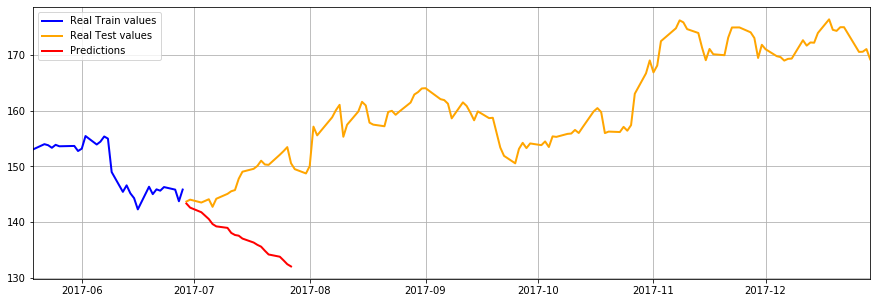

In [40]:
plt.figure(figsize=(15, 5))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train_index[-28:], train[-28:], lw=2, color='blue')
plt.plot(test_index, test, lw=2, color='orange')

plt.plot(test_index[:20], true_predictions, lw=2, color='red')

days = []
for i in range(1, 21):
    days.append('day'+str(i))
    
plt.xticks()

plt.legend(['Real Train values', 'Real Test values', 'Predictions'])

## Prediction set for next 20 days 2

In [55]:
predictions2 = []

# Initialize prediction process using very last 40 values within train set, 
# in order to predict first 'future' value.
# Tricky thing is that we actualyy know that future value, 
# since we approximate not further than length of the test set.

first_batch2 = train_norm[-n_input2:].values.reshape((1, n_input2)) # numpy.ndarray (1, 40)

# Predict 20 sessions ahead
# Note that later prediction will base on previous predictions what makes further outputs more noisy 
for i in range(20):
    y_hat2 = model2.predict(first_batch2).squeeze() # numpy.ndarray ()
    predictions2.append(y_hat2.tolist())
    
    next_batch2 = np.append(first_batch2, y_hat2)[1:].reshape((1, n_input2)) # numpy.ndarray (1, 40)
    first_batch2 = next_batch2

In [56]:
# Do the inversion of normalized values
true_predictions2 = scaler.inverse_transform([predictions2])[0]

# True predictions series object
df_true_predictions2 = pd.Series(true_predictions2, test_index[:20])

___

### ANN Predictions against the Real Values 

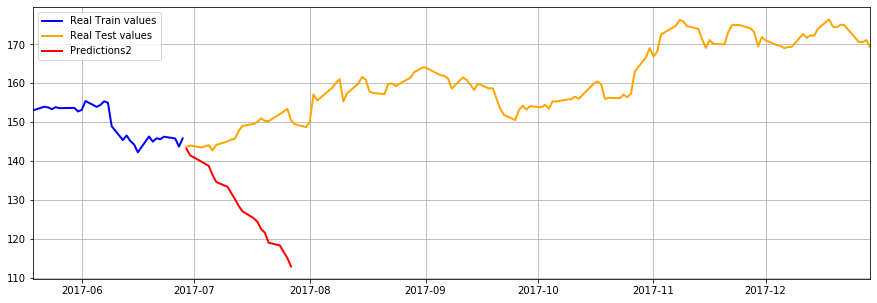

In [57]:
plt.figure(figsize=(15, 5))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train_index[-28:], train[-28:], lw=2, color='blue')
plt.plot(test_index, test, lw=2, color='orange')

plt.plot(test_index[:20], true_predictions2, lw=2, color='red')

days = []
for i in range(1, 21):
    days.append('day'+str(i))
    
plt.xticks()

plt.legend(['Real Train values', 'Real Test values', 'Predictions2'])

___

### Rolling mean against real data and predictions from ANN

In [ ]:
# Prediction of 20 sessions ahead
# It is rolling average with 20 days span
# Further predictions base on previous

predictions_20_avg = []

batch = train[-20:].squeeze()
for i in range(20):
    prediction = batch.mean()
    predictions_20_avg.append(prediction)
    
    
    next_batch = np.append(batch[1:], prediction)
    batch = next_batch

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(np.arange(-9, 1),
         train[-10:],
         color='blue')

plt.plot(np.arange(1, len(test)+1),
         test,
         color='orange')

plt.plot(np.arange(1, len(true_predictions)+1),
         true_predictions,
         color='red')

plt.plot(np.arange(1, len(predictions_20_avg)+1),
         predictions_20_avg,
         color='grey')

plt.legend(['Real Train Data', 'Real Test Data', 'ANN Predictions', '20 Days AVG Predictions'])

____

In [ ]:
# Upper and lower bounds of avg +- std (20-days-span)

mean_20 = df[['Close']].rolling(window=20).mean()
std_20 = df[['Close']].rolling(window=20).std()

# Lower
std_minus = mean_20 - std_20
std_minus.dropna(inplace=True)

# Upper
std_plus = mean_20 + std_20
std_plus.dropna(inplace=True)

In [ ]:
# Plot 20 days avg window including sts, against real and predicted data
plt.figure(figsize=(15, 5))
plt.plot(df_close, lw=3, color='blue')
plt.plot(mean_20, lw=2, color='orange')

plt.fill_between(std_plus.index, std_minus.Close, std_plus.Close, alpha=0.3, color='orange')

plt.plot(df_true_predictions, lw=2, color='red', ls='--')


plt.autoscale(tight=True, axis='y')

plt.legend(['Close price', '20 days rolling avg. +/- 20 day rolling std.', 'Predictions'])

plt.xlim('2017-01-01', '2017-12-29')
plt.ylim(100, 180)